In [1]:
#image analysis
import sys
sys.path.append("../../")

import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
p.save_folder = "G:/DREAM/from_github/thesis/Figures/biophysical_validation"
p.figsize = (10,5)
p.fontsize = 18
p.fonttick = 12

import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline



from mvgavg import mvgavg



from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     #('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 2))),
     ('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 2))),
     ('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 2, 1, 2))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 2, 1, 2, 1, 2))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
keys = list(linestyles.keys())


In [2]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE" 
file_folder = 'LEAF1_DO0/'#G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2021_11_03_OJIP_calibration/FOLDER_2021_11_03_OJIP_actiivated_1/'
#askdirectory(title = 'Select an experiment folder', initialdir="G:/DREAM/from_github/PAMFluo/Experiments")  # pops up a window to select your file 
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'
file_folder

'LEAF1_DO0/'

In [3]:
def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * (1 - np.exp(-xdata/tau))**1.25 + y0


def get_fit(decay, time, give_y = False):    

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-10:])
    x0 = [start, 1/10, stop]
    time = time-time[0]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    
    if give_y:
        return np.array(parameters_estimated.x), exp_decay(parameters_estimated.x, time)
    else:
        return np.array(parameters_estimated.x)

def make_fit(decay, time_array):
    params, ypred = get_fit(decay, time_array, give_y = True)
    plt.plot(time_array, ypred, label = params[1])
    plt.plot(time_array, decay, '.')
    plt.xlabel("intensity (µeins/m²/s))")
    plt.ylabel("fluorescence")
    #plt.legend()

def regression_lineaire(X, Y, details = True):

    model = linear_model.OLS(Y, X) #Linear regression
    results = model.fit()
    [a] = results.params #parameters of the affine curve
    Yreg = a*X #regression curve

    return Yreg, a, results.summary()



In [4]:
os.listdir(file_folder)

['2022-01-17_13_21_OJIP_pulse',
 '2022-01-17_13_22_OJIP_pulse',
 '2022-01-17_13_23_OJIP_pulse',
 '2022-01-17_13_24_OJIP_pulse',
 '2022-01-17_13_26_OJIP_pulse',
 '2022-01-17_13_27_OJIP_pulse',
 '2022-01-17_13_28_OJIP_pulse',
 '2022-01-17_13_29_OJIP_pulse',
 '2022-01-17_13_30_OJIP_pulse',
 '2022-01-17_13_31_OJIP_pulse',
 '2022-01-17_13_32_OJIP_pulse',
 '2022-01-17_13_33_OJIP_pulse',
 '2022-01-17_13_34_OJIP_pulse',
 '2022-01-17_13_35_OJIP_pulse',
 '2022-01-17_13_36_OJIP_pulse',
 '2022-01-17_13_37_OJIP_pulse',
 '2022-01-17_13_38_OJIP_pulse',
 '2022-01-17_13_39_OJIP_pulse',
 '2022-01-17_13_41_OJIP_pulse',
 '2022-01-17_13_42_OJIP_pulse',
 '2022-01-17_13_43_OJIP_pulse',
 '2022-01-17_13_44_OJIP_pulse',
 '2022-01-17_13_45_OJIP_pulse',
 '2022-01-17_13_46_OJIP_pulse']

NameError: name 'data_sequence' is not defined

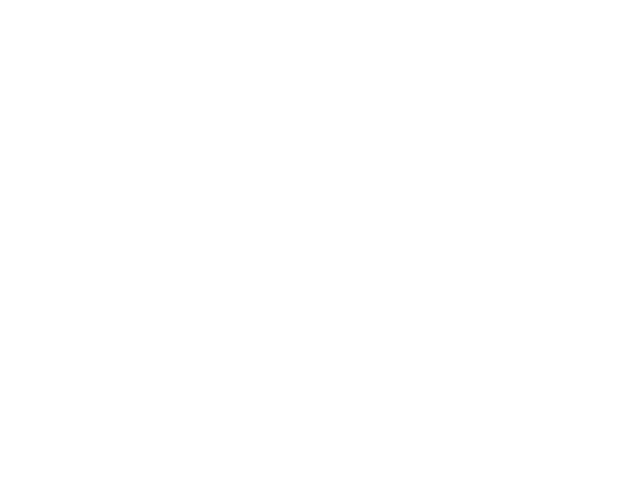

In [5]:
plt.figure()
time_array = np.array(data_sequence["time (s) intensity"])
fluo = np.array(data_sequence["voltage (V) intensity"])
#xrange = (fluo > 0.04)*(time_array<0.0006)

plt.plot(mvgavg(time_array, 100), mvgavg(fluo, 100))

In [6]:
5
def fit_OJIP(f, W = 100, red = 50):
    file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
    file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
    (voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
    data_sequence = pd.read_csv(file_path)
    amp_seq = pd.read_csv(file2)

    V = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram")
    intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
    #fluo = amplitude

    time_array = np.array(data_sequence["time (s) intensity"])
    fluo = np.array(data_sequence["voltage (V) intensity"])
    blank = np.mean(fluo[0:10])
    fluo = fluo-blank
    fluoref = fluo/fluo.max()
    xrange = (fluoref>0.2)*(time_array<(1/(red*np.log(intensity))))


    xrange = (fluo>0.006)*(time_array<(4/intensity))
    x = time_array[xrange]
    y = fluo[xrange]

    W = 100
    x = mvgavg(x, W)
    y = mvgavg(y, W)

    #axs[0].plot(x*1000, y, '.' , label = voltage)
    params, ypred = get_fit(y, x, give_y = True)

    FM = np.mean(fluo[-1000:])
    F0 = np.mean(fluo[0:4])
    return x, y, ypred, params[1], intensity, (FM-F0)



In [7]:
list_folder = ['LEAF1_DO0', 'LEAF2_DO0', 'LEAF3_DO0', 'LEAF4_DO0', 'LEAF5_DO0', 'LEAF6_DO0', 'LEAF7_DO0', 'LEAF8_DO0', "chloroplast_of_the_cat"]#, "LEAF8_DO1", 'ALGAE1_DO0']
list_folder = ['LEAF1_DO0', 'LEAF7_DO0', 'LEAF8_DO0', "chloroplast_of_the_cat"]#, "LEAF8_DO1", 'ALGAE1_DO0']


In [6]:
tau = np.array(output)[:,3]

inte = np.array(output)[:,4]
y = np.array(output)[:,5]
plt.figure()

#plt.plot(inte, y/y.max())
#plt.plot(inte, (1/tau)/((1/tau).max()))
plt.plot(inte, 1/(y*tau))

NameError: name 'output' is not defined

In [ ]:
for red in [50]:
    plt.figure()

    for file_folder in list_folder:#, 'ALGAELADI_DO0' ]:


            output = Parallel(n_jobs=-1)(delayed(fit_OJIP)(f, red = red) for f in glob.glob(file_folder + "/*")[1:-1])
            tau = np.array(output)[:,3]
            inte = np.array(output)[:,4]
            max_int = np.array(output)[:,5]
            plt.plot(inte, 1/(tau*max_int), '.', label = file_folder)

    plt.xlabel("intensity µeins/m²/s")
    plt.ylabel("rate (1/s)")
    plt.legend()

G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
450.0
chloroplast_of_the_cat\2022-06-23_18_47_OJIP_pulse
8.049966474161161e-05


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
409.0
chloroplast_of_the_cat\2022-06-23_18_49_OJIP_pulse
9.03900111669486e-05


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
368.0
chloroplast_of_the_cat\2022-06-23_18_51_OJIP_pulse
0.00010673570647534298


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
327.0
chloroplast_of_the_cat\2022-06-23_18_53_OJIP_pulse
0.0001148005285273819


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
286.0
chloroplast_of_the_cat\2022-06-23_18_55_OJIP_pulse
0.0001361586279560549


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
245.0
chloroplast_of_the_cat\2022-06-23_18_57_OJIP_pulse
0.00016015483244675562


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
204.0
chloroplast_of_the_cat\2022-06-23_18_58_OJIP_pulse
0.0001797387582064994


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
163.0
chloroplast_of_the_cat\2022-06-23_19_00_OJIP_pulse
0.00024351691024554419


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
122.0
chloroplast_of_the_cat\2022-06-23_19_02_OJIP_pulse
0.0003142261716377867


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
81.0
chloroplast_of_the_cat\2022-06-23_19_04_OJIP_pulse
0.0009836478389145733


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
40.0
chloroplast_of_the_cat\2022-06-23_19_06_OJIP_pulse
0.000556988202431218


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
0.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\3188962243.py:20: RuntimeWarning: invalid value encountered in log
  xrange = (fluoref>0.2)*(time_array<(1/(red*np.log(intensity))))


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
20.0
G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
0.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_12744\3188962243.py:20: RuntimeWarning: invalid value encountered in log
  xrange = (fluoref>0.2)*(time_array<(1/(red*np.log(intensity))))


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram
36.0


ValueError: zero-size array to reduction operation maximum which has no identity

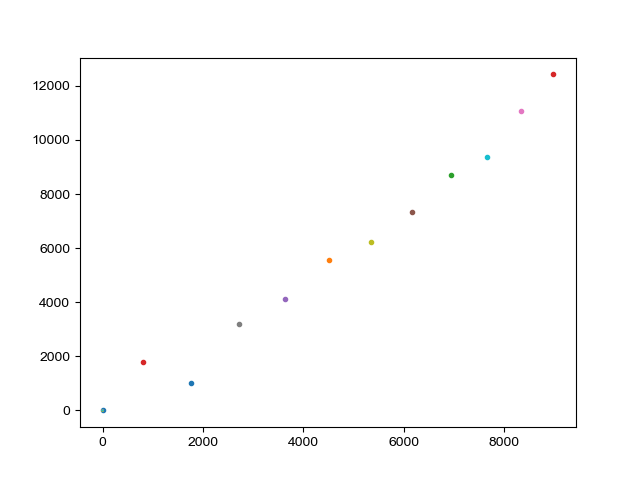

In [6]:
plt.figure()
plt.plot(0,0,".")
red = 150
files_folder = ['chloroplast_of_the_cat', 'LEAF1_DO0', 'LEAF2_DO0', 'LEAF3_DO0']#'chloroplast_on_pad'
for file_folder in files_folder: 
    for f in glob.glob(file_folder + "/*"):
        file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
        file2 = glob.glob(f + "/*output_plot.csv")[0]
        (voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
        data_sequence = pd.read_csv(file_path)
        amp_seq = pd.read_csv(file2)

        V = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_16_23_bode_diagram")
        intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
        #fluo = amplitude

        time_array = np.array(data_sequence["time (s) intensity"])
        fluo = np.array(data_sequence["voltage (V) intensity"])
        fluoref = fluo/fluo.max()
        xrange = (fluoref>0.2)*(time_array<(1/(red*np.log(intensity))))
        print(voltage)
        if voltage !=20.0 and voltage != 0.0:

            x = time_array[xrange]
            y = fluo[xrange]

            W = 100
            x = mvgavg(x, W)
            y = mvgavg(y, W)

            #axs[0].plot(x*1000, y, '.' , label = voltage)
            params, ypred = get_fit(y, x, give_y = True)

            FM = np.mean(fluo[-1000:])
            F0 = np.mean(fluo[0:4])
            tau = params[1]
            print(f)
            print(tau)

            plt.plot(x,y)
            plt.plot(x, ypred)

            plt.plot(intensity, 1/(params[1]), '.', label = file_folder)

            
            


In [ ]:
for red in [50]:
    tau_list= []
    inte_list = []
    desc_list = []
    plt.figure()

    for file_folder in list_folder:#, 'ALGAELADI_DO0' ]:
        print(file_folder)
        for f in  glob.glob(file_folder + "/*")[1:-1]:
            x, y, ypred, tau, intensity, dF = fit_OJIP(f, red = red)
            plt.loglog(intensity, 1/(tau), '.', label = file_folder)
            tau_list.append(tau)
            inte_list.append(intensity)
            desc_list.append(file_folder)

    plt.xlabel("intensity µeins/m²/s")
    plt.ylabel("rate (1/s)")
    plt.legend()
    

LEAF1_DO0
G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram
LEAF7_DO0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13652\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


In [ ]:
inte_chloro = np.load("intensity_chloro.npy")
tau_chloro = np.load("tau_chloro.npy")

In [13]:
tau_chloro

NameError: name 'tau_chloro' is not defined

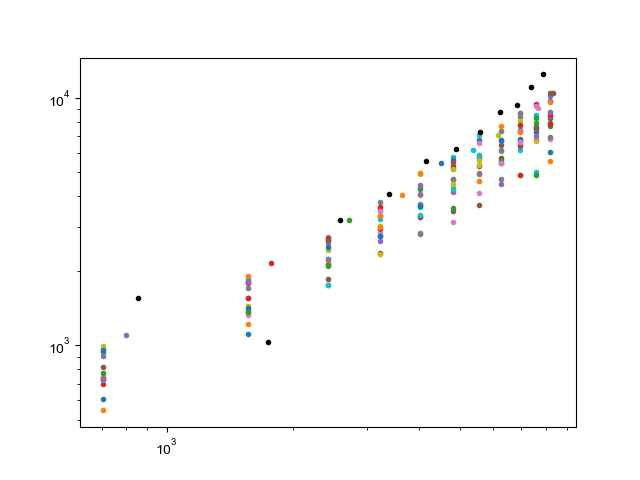

In [18]:
plt.figure()
for i, inte in enumerate(inte_list):
    plt.loglog((inte).astype(float), 1/tau_list[i].astype(float), '.')
    
plt.loglog(inte_chloro, tau_chloro, '.k')

['ALGAE1_DO0\\2022-01-17_15_47_OJIP_pulse']
0.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_49_OJIP_pulse']
72.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_51_OJIP_pulse']
145.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_53_OJIP_pulse']
218.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_55_OJIP_pulse']
290.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_58_OJIP_pulse']
363.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF8_DO1\\2022-01-17_19_41_OJIP_pulse']
0.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF8_DO1\\2022-01-17_19_43_OJIP_pulse']
109.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF8_DO1\\2022-01-17_19_45_OJIP_pulse']
181.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF8_DO1\\2022-01-17_19_47_OJIP_pulse']
254.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF8_DO1\\2022-01-17_19_49_OJIP_pulse']
363.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF8_DO1\\2022-01-17_19_51_OJIP_pulse']
400.0


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram


C:\Users\Alienor\AppData\Local\Temp\ipykernel_6628\1310913445.py:9: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.25 + y0


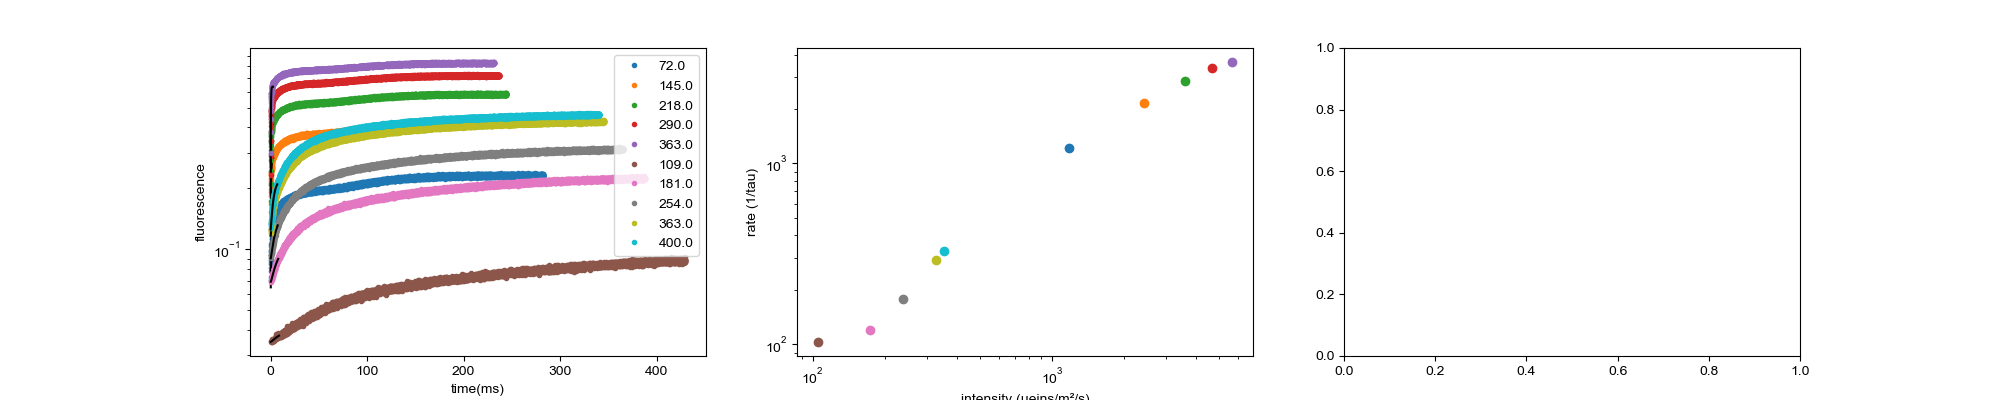

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

XX = []
YY = []


W = 1000
start = 60
stop = 3000

file_folder = 'ALGAE1_DO0'
for ff, file_folder in enumerate(["ALGAE1_DO0", "LEAF8_DO1"]): #["LEAF8_DO1", "LEAF8_DO0"]:
    for i, f in enumerate(glob.glob(file_folder + "/*")[0:12:2]):
            print( glob.glob(f))
            file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
            file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
            (voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
            print(voltage)
            data_sequence = pd.read_csv(file_path)
            amp_seq = pd.read_csv(file2)

            V = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram")
            intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
            #fluo = amplitude
            if voltage == 0:
                blank_level = np.mean(np.array(data_sequence["voltage (V) intensity"]))
            if voltage>0:

                time_array = np.array(data_sequence["time (s) intensity"])
                fluo = np.array(data_sequence["voltage (V) intensity"]) - blank_level
                xrange = (fluo > 0.04)*(time_array<0.0006)
                #fluo = fluo/np.mean(fluo[-200:])#*intensity
                amplitude = np.array(amp_seq["voltage (V) intensity"])
                #intensity = np.mean(amplitude[1500:2000])

                fluoref = fluo/fluo.max()
                if ff==0:
                    xrange = (fluoref>0.2)*(time_array<(1/(50*np.log(intensity))))
                else:                  
                    xrange = (fluoref>0.2)*(time_array<(1/(25*np.log(intensity))))
                    
                x = time_array[xrange]
                y = fluo[xrange]

                params, ypred = get_fit(y, x, give_y = True)

                W=100
                xrange = (fluoref>0.2)*(time_array<(2/(np.log(intensity))))

                x2 = mvgavg(time_array[xrange], W, binning=True)
                y2 = mvgavg(fluo[xrange], W, binning = True)
                #axs[0].plot(x*1000, y, '.' , label = voltage)

                axs[0].semilogy(x2*1000, y2, '.' , label = voltage)
                axs[0].semilogy(x*1000, ypred, '-k')
                #axs[0].semilogx(x2*1000, y2, '.' , label = voltage)
                #axs[0].semilogx(x*1000, ypred, '-k')

                axs[0].set_xlabel("time(ms)")
                axs[0].set_ylabel("fluorescence")
                axs[1].loglog(intensity, 1/params[1], 'o')
                axs[1].set_xlabel("intensity (µeins/m²/s)")
                axs[1].set_ylabel("rate (1/tau)")            
                XX.append(intensity)
                YY.append(1/params[1])
                #axs[2].plot(amplitude, label = voltage)
                axs[0].legend()
                #axs[2].legend()


            #axs[3].scatter(voltage[i], FQ, color = 'r')
    #plt.legend()


In [22]:
V1 = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram")

for i in [300, 200, 50, 30, 20, 80]:
    print("HL:",V1.get_intensity_voltage("blue", 0, i/100)*1e6)



G:/DREAM/from_github/PAMFluo/Experiments/2022-01-13_12_02_bode_diagram
HL: 3853.8293076942136
HL: 2662.916275624101
HL: 619.1248606229838
HL: 329.6659778051732
HL: 183.85765570274154
HL: 1047.1942431604605


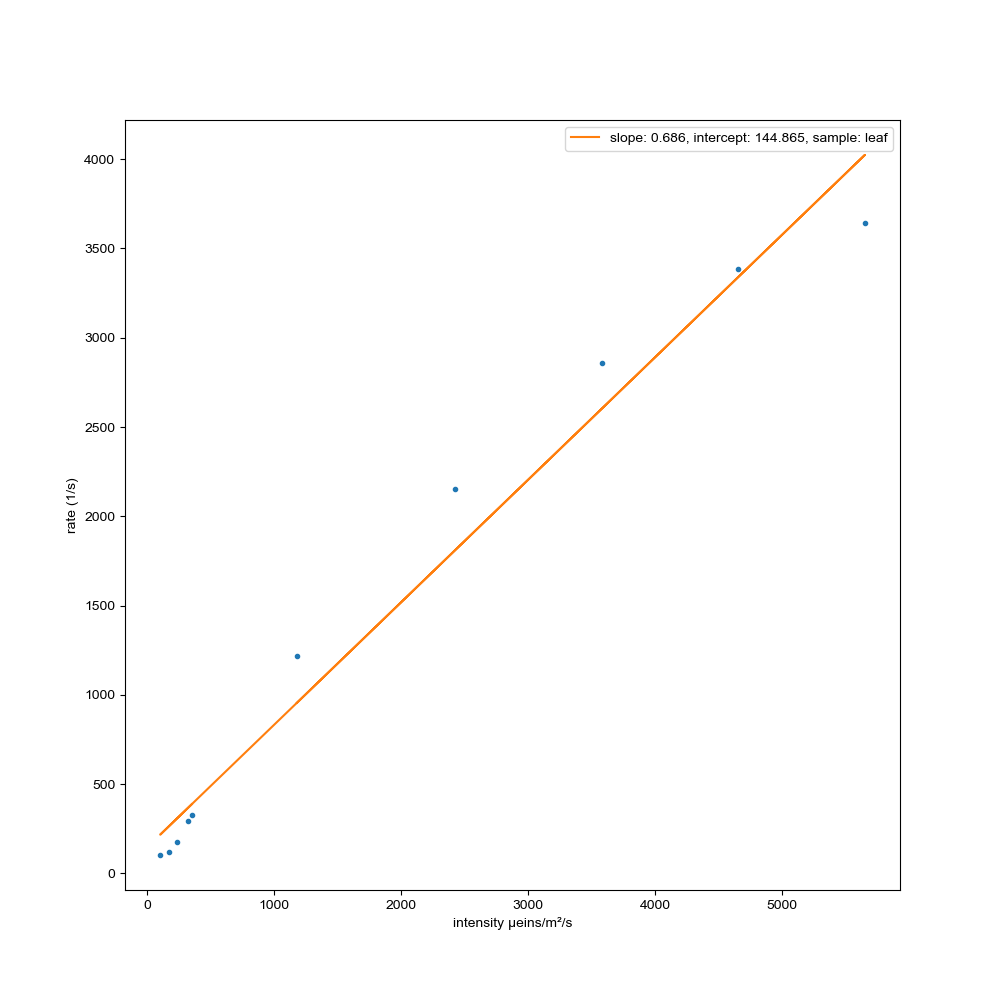

In [23]:
from alienlab.regression_func import regression_affine
start = 0
stop = 10
plt.figure(figsize = (10,10))
Yreg, a, b, pp = regression_affine(np.array(XX[start:stop]), np.array(YY[start:stop]))
plt.plot(XX, YY, '.')
file = 'leaf'
plt.plot(XX[start:stop] ,Yreg, '-', label = "slope: %0.3f, intercept: %0.3f, sample: %s"%(a, b,file))
plt.xlabel("intensity µeins/m²/s")
plt.ylabel("rate (1/s)")
plt.legend()



In [24]:
np.save("OJIP_activated_3.npy", YY)

FileNotFoundError: [Errno 2] No such file or directory: 'OJIP_control.npy'

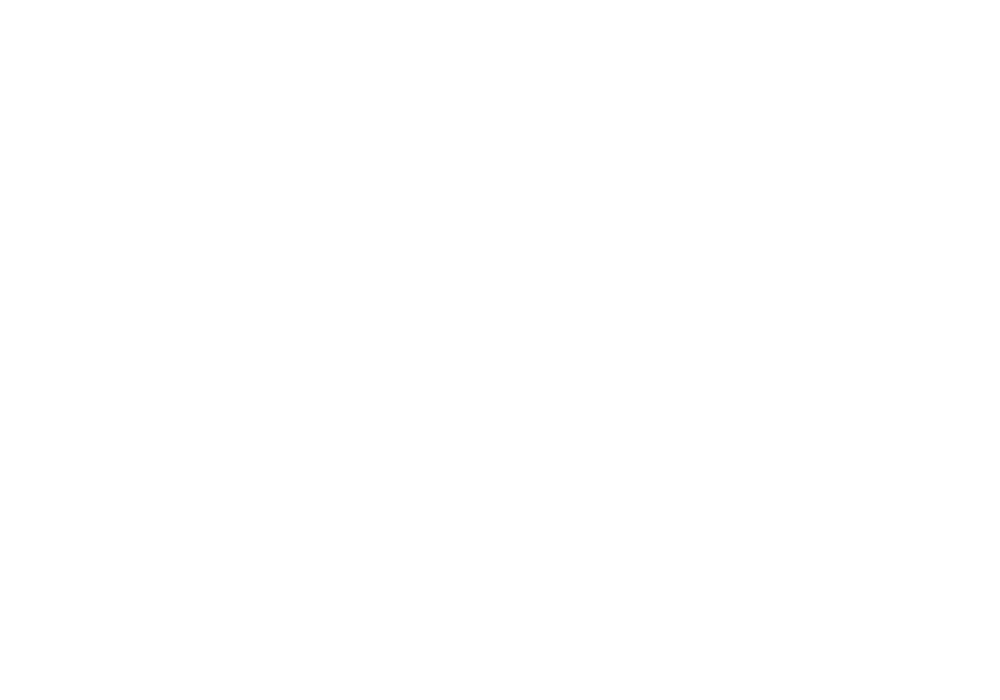

In [25]:
from alienlab.regression_func import regression_affine
start = 2
stop = -1
plt.figure(figsize = (10,7))
for file in ["control", "activated_1", "activated_2", "activated_3"]:
    filepath = "OJIP_"+file+".npy"
    YY = np.load(filepath)
    Yreg, a, b, pp = regression_affine(np.array(XX[start:stop]), np.array(YY[start:stop]))
    plt.plot(XX, YY, '.')
    plt.plot(XX[start:stop] ,Yreg, '-', label = "slope: %0.3f, intercept: %0.3f, sample: %s"%(a, b,file))
    plt.xlabel("intensity µeins/m²/s")
    plt.ylabel("rate (1/s)")
plt.legend()


pp

In [ ]:
from alienlab.regression_func import regression_affine
start = 2
stop = 10
Yreg, a, b, pp = regression_affine(np.array(XXX[start:stop]), np.array(YYY[start:stop]))
plt.figure()
plt.plot(XXX, YYY, '.')
plt.plot(XXX[start:stop] ,Yreg, '-')
plt.xlabel("intensity µeins/m²/s")
plt.ylabel("rate (1/s)")

pp

In [ ]:
plt.figure()
time_array = np.array(data_sequence["time (s) intensity"])
fluo = np.array(data_sequence["voltage (V) intensity"])
xrange = fluo>0.006
x = time_array[xrange]
y = fluo[xrange]
        
W = 100
x = mvgavg(x, W)
y = mvgavg(y, W)
            
plt.plot(x, y)

['ALGAE1_DO0\\2022-01-17_15_47_OJIP_pulse']
0.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_49_OJIP_pulse']
72.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_51_OJIP_pulse']
145.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_53_OJIP_pulse']
218.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_55_OJIP_pulse']
290.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['ALGAE1_DO0\\2022-01-17_15_58_OJIP_pulse']
363.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram


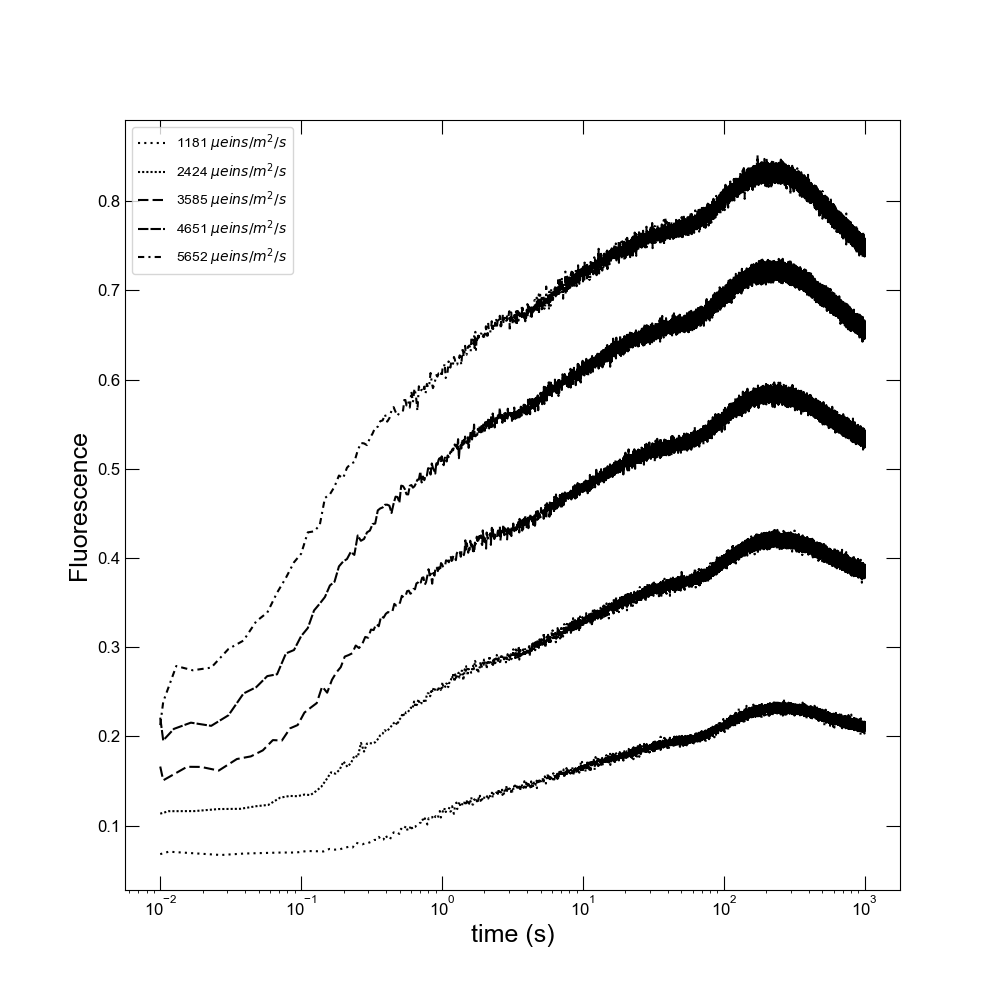

In [35]:

XX = []
YY = []


W = 1000
start = 60
stop = 3000
for file_folder in ["ALGAE1_DO0"]:#list_folder:# ["LEAF1_DO0"]: #["LEAF8_DO1", "LEAF8_DO0"]:
    fig = plt.figure(figsize=(10,10))

    for i, f in enumerate(glob.glob(file_folder + "/*")[0:12:2]):
            print( glob.glob(f))
            file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
            file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
            (voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
            print(voltage)
            data_sequence = pd.read_csv(file_path)
            amp_seq = pd.read_csv(file2)

            V = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram")
            intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
            #fluo = amplitude
            if voltage>0:

                time_array = np.array(data_sequence["time (s) intensity"])
                fluo = np.array(data_sequence["voltage (V) intensity"])
                fluo = fluo - np.mean(fluo[0:10])
                xrange = (fluo > 0.04)*(time_array<0.0006)
                #fluo = fluo/np.mean(fluo[-200:])#*intensity
                amplitude = np.array(amp_seq["voltage (V) intensity"])
                #intensity = np.mean(amplitude[1500:2000])

                fluoref = fluo/fluo.max()
                xrange = (fluoref>0.2)*(time_array<(100/(np.log(intensity))))
                
                x = time_array[xrange]
                y = fluo[xrange]
                flog = []
                tlog = []
                j=0
                while j < len(x):
                    window = 1 + int(10*np.log(j+ 1)/np.log(10))
                    data = y[j:j+window]
                    flog.append(np.mean(data))
                    tlog.append(x[j]*1000)
                    j = j + window
                    

                plt.semilogx(np.array(tlog)-tlog[0]+1e-2, flog, 'k', linestyle =linestyles[keys[i]] , label = r"%d $\mu eins/m^2/s$"%intensity)


                plt.legend()

            #axs[3].scatter(voltage[i], FQ, color = 'r')
    #plt.legend()
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
    plt.xlabel("time (s)", fontsize=p.fontsize)
    plt.ylabel("Fluorescence", fontsize = p.fontsize)
    plt.legend()    
    plt.savefig(p.save_folder + '/OJIP_intensity_range_%s.pdf'%file_folder)

['LEAF1_DO0\\2022-01-17_13_21_OJIP_pulse']
0.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_22_OJIP_pulse']
36.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_23_OJIP_pulse']
72.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_24_OJIP_pulse']
109.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_26_OJIP_pulse']
145.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_27_OJIP_pulse']
181.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_28_OJIP_pulse']
218.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_29_OJIP_pulse']
254.0
G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram
['LEAF1_DO0\\2022-01-17_13_30_OJIP_pulse']
2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram


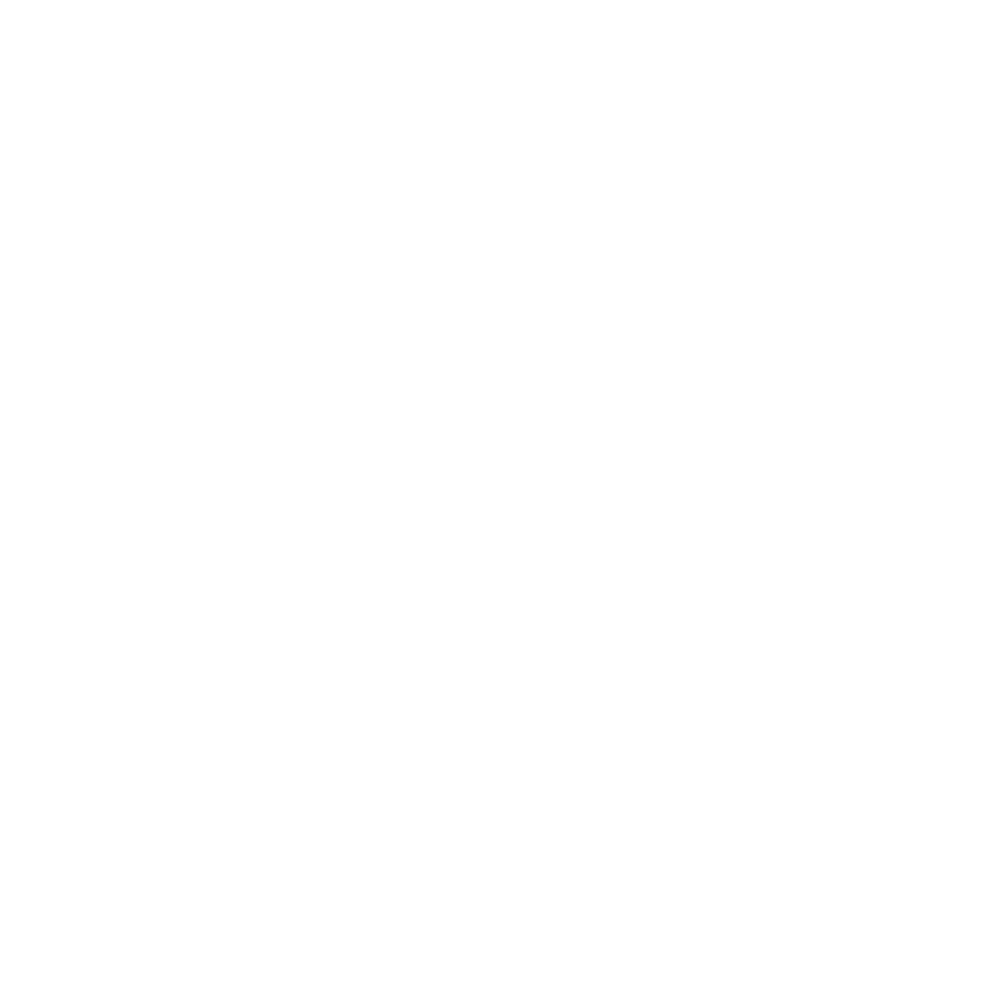

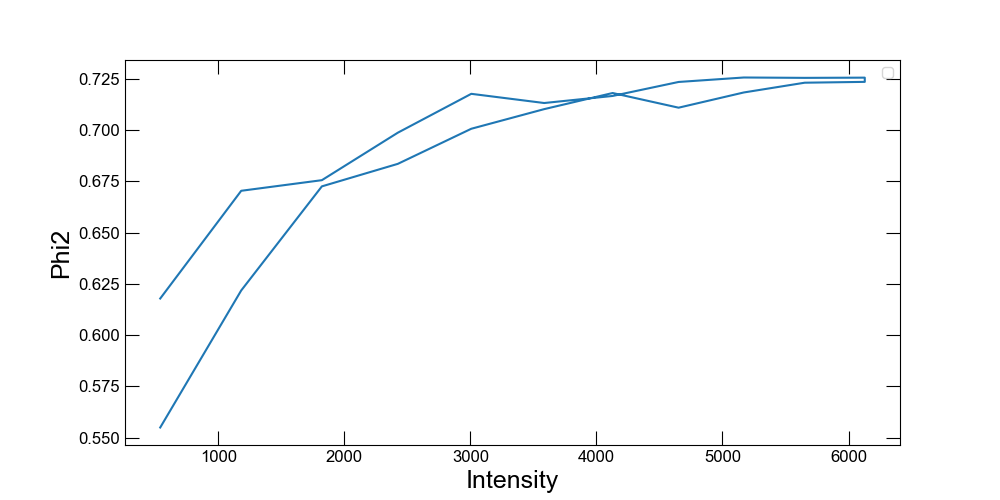

In [36]:

XX = []
YY = []


W = 1000
start = 60
stop = 3000
fig = plt.figure(figsize=(10,10))
for file_folder in ["LEAF1_DO0"]: #["LEAF8_DO1", "LEAF8_DO0"]:
    pat1 = []
    pat2 = []
    intit = []
    for i, f in enumerate(glob.glob(file_folder + "/*")):
            print( glob.glob(f))
            file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
            file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
            (voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
            print(voltage)
            data_sequence = pd.read_csv(file_path)
            amp_seq = pd.read_csv(file2)

            V = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram")
            intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
            #fluo = amplitude
            if voltage>0:

                time_array = np.array(data_sequence["time (s) intensity"])
                fluo = np.array(data_sequence["voltage (V) intensity"])
                fluo = fluo - np.mean(fluo[0:10])
                xrange = (fluo > 0.04)*(time_array<0.0006)
                #fluo = fluo/np.mean(fluo[-200:])#*intensity
                amplitude = np.array(amp_seq["voltage (V) intensity"])
                #intensity = np.mean(amplitude[1500:2000])

                fluoref = fluo/fluo.max()
                xrange = (fluoref>0.2)*(time_array<(100/(np.log(intensity))))
                
                x = time_array[xrange]
                y = fluo[xrange]
                flog = []
                tlog = []
                j=0
                while j < len(x):
                    window = 1 + int(10*np.log(j+ 1)/np.log(10))
                    data = y[j:j+window]
                    flog.append(np.mean(data))
                    tlog.append(x[j]*1000)
                    j = j + window
                    
                pat1.append(np.mean(flog[0:4]))
                pat2.append(np.mean(flog[-15:-5]))
                intit.append(intensity)
                #plt.scatter(intensity, flog[0], linestyle =linestyles[keys[i%len(keys)]] , label = r"%d $\mu eins/m^2/s$"%intensity)
                #plt.scatter(intensity, flog[-1], linestyle =linestyles[keys[i%len(keys)]] , label = r"%d $\mu eins/m^2/s$"%intensity)

                XX.append(intensity)
                YY.append(1/params[1])
                #plt.legend()


    plt.figure(figsize=p.figsize)
    pat1 = np.array(pat1)
    pat2 = np.array(pat2)
    #plt.plot(pat1, pat2, '.')
    #Yreg, a, r = regression_lineaire(np.array(pat1), np.array(pat2), details = True)
    #plt.plot(pat1, Yreg, label  = "linear coefficient: %0.2f"%a)
    plt.plot(intit, (pat2-pat1)/pat2)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
    plt.xlabel("Intensity", fontsize=p.fontsize)
    plt.ylabel("Phi2", fontsize = p.fontsize)
    plt.legend()    
    plt.savefig(p.save_folder + '/phi2_evolution_intensity.pdf')                
#ax = plt.gca()
#ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
#plt.xlabel("time (s)", fontsize=p.fontsize)
#plt.ylabel("Fluorescence", fontsize = p.fontsize)
#plt.legend()    
#plt.savefig(p.save_folder + '/OJIP_intensity_range.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


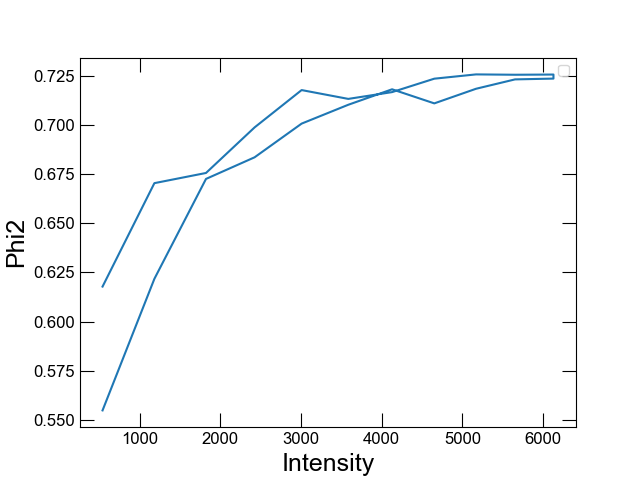

In [37]:
plt.figure()
pat1 = np.array(pat1)
pat2 = np.array(pat2)
#plt.plot(pat1, pat2, '.')
#Yreg, a, r = regression_lineaire(np.array(pat1), np.array(pat2), details = True)
#plt.plot(pat1, Yreg, label  = "linear coefficient: %0.2f"%a)
plt.plot(intit, (pat2-pat1)/pat2)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
plt.xlabel("Intensity", fontsize=p.fontsize)
plt.ylabel("Phi2", fontsize = p.fontsize)
plt.legend()    
plt.savefig(p.save_folder + '/phi2_evolution_intensity.pdf')